In [2]:
import os
import sys; sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from firelab.config import Config
from src.utils.metrics import (
    compute_joined_zst_acc_history,
    compute_ausuc_matrix,
    compute_individual_zst_accs_matrix
)


exps_dir = '../experiments'
methods = ['Basic', 'EWC', 'MAS', 'A-GEM', 'MeRGAN']
dataset = 'CUB'
exps = {
    'A-GEM': [f for f in os.listdir(exps_dir) if f.startswith('agem-')],
    'Basic': [f for f in os.listdir(exps_dir) if f.startswith('basic-')],
    'EWC': [f for f in os.listdir(exps_dir) if f.startswith('ewc-')],
    'MAS': [f for f in os.listdir(exps_dir) if f.startswith('mas-')],
    'MeRGAN': [f for f in os.listdir(exps_dir) if f.startswith('mergazsl-')],
}

configs = {exp: [Config.load(f'{exps_dir}/{p}/config.yml') for p in exps[exp]] for exp in exps}
logits = {exp: np.array([np.load(f'{exps_dir}/{p}/custom_data/logits_history.npy') for p in exps[exp]]) for exp in exps}
class_splits = {exp: np.array([np.load(f'{exps_dir}/{p}/custom_data/class_splits.npy') for p in exps[exp]]) for exp in exps}

# Let's keep only good ZST accs for MAS
# non_diverged_mas_exps = [i for i, accs in enumerate(zst_accs['MAS']) if accs.mean() > 0.4]
# zst_accs['MAS'] = zst_accs['MAS'][non_diverged_mas_exps]
# lca_scores['MAS'] = lca_scores['MAS'][non_diverged_mas_exps]
# ausuc_scores['MAS'] = ausuc_scores['MAS'][non_diverged_mas_exps]
# ausuc_accs['MAS'] = ausuc_accs['MAS'][non_diverged_mas_exps]

# plt.figure(figsize=(15, 7))
# plt.title(f'ZST accuracy on {dataset}')

# # # plt.plot(np.arange(1, 21), agem_scores.mean(axis=0), color='red', marker='^', label='A-GEM old (5 runs)')
# # # plt.fill_between(np.arange(1, 21),
# # #          agem_scores.mean(axis=0) + agem_scores.std(axis=0),
# # #          agem_scores.mean(axis=0) - agem_scores.std(axis=0),
# # #          color='red', alpha=0.05)

# # # plt.plot(np.arange(1, 21), basic_scores.mean(axis=0), color='blue', label='Baseline (averaged across 5 runs)')
# # # plt.fill_between(np.arange(1, 21),
# # #          basic_scores.mean(axis=0) + basic_scores.std(axis=0),
# # #          basic_scores.mean(axis=0) - basic_scores.std(axis=0),
# # #          color='blue', alpha=0.05)

# # task_indices = np.arange(1, 11)
# # task_indices = np.arange(1, 18)
# task_indices = np.arange(1, 11)
# for method in methods:
#     plt.plot(task_indices, zst_accs[method].mean(axis=0), label=method)

# plt.xlabel('Task ID')
# plt.ylabel('ZST accuracy for a task')
# plt.xticks(task_indices)
# plt.legend()
# plt.grid()

In [4]:
from src.dataloaders.cub import load_train_test_split, load_labels
from src.dataloaders.utils import read_column

data_dir = '../data/CUB2011'
img_paths = read_column(f'{data_dir}/images.txt', 1)
is_train = False
train_test_split = load_train_test_split(data_dir)
img_paths = [p for (p, train) in zip(img_paths, train_test_split) if train == is_train]
labels = load_labels(img_paths)

In [13]:
hpo_exps = {
    'Basic': [
        ('hp.optim_kwargs.lr', 0.005),
        ('hp.optim_kwargs.lr', 0.03),
    ],
    'A-GEM': [
        ('hp.optim_kwargs.lr', 0.005),
        ('hp.optim_kwargs.lr', 0.03),
    ],
    'MAS': [
        ('hp.synaptic_strength', 0.001),
        ('hp.synaptic_strength', 0.01),
        ('hp.synaptic_strength', 0.1),
    ],
    'EWC': [
        ('hp.synaptic_strength', 0.001),
        ('hp.synaptic_strength', 0.01),
        ('hp.synaptic_strength', 0.1),
    ],
    'MeRGAN': [
        ('hp.joint_cls_training_loss_coef', 10),
        ('hp.joint_cls_training_loss_coef', 1),
        ('hp.joint_cls_training_loss_coef', 0.1),
        ('hp.joint_cls_training_loss_coef', 0.01),
        ('hp.model_config.model_distill_coef', 0.01),
        ('hp.model_config.model_distill_coef', 0.0001),
    ],
}

In [68]:
def load_labels(seed):
    return np.load(f'../labels/labels{seed}.npy').tolist()

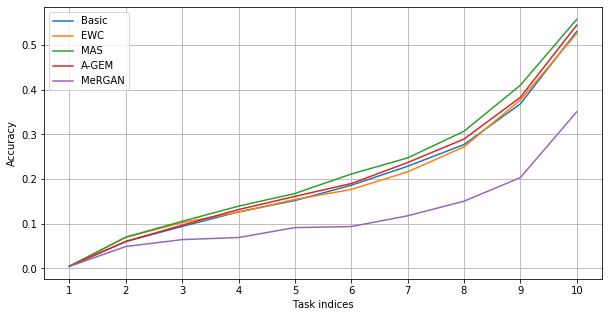

In [171]:
from tqdm import tqdm

plt.figure(figsize=(10, 5))
all_acc_histories = []
task_indices = np.arange(1, 11)
best_hpo_results_idx = {}

for method in methods:
    curr_acc_histories = []
    
    for hpo_exp_key, hpo_exp_value in hpo_exps[method]:
        curr_hpo_idx = [i for i, c in enumerate(configs[method]) if c.get(hpo_exp_key) == hpo_exp_value]
        random_seeds = [configs[method][i].random_seed for i in curr_hpo_idx]
        curr_logits = [logits[method][i] for i in curr_hpo_idx]
        curr_targets = [load_labels(s) for s in random_seeds]
        curr_class_splits = [class_splits[method][i] for i in curr_hpo_idx]
        
        acc_histories = [compute_joined_zst_acc_history(ls, trg, cs) for ls, trg, cs in zip(curr_logits, curr_targets, curr_class_splits)]
        acc_histories = np.array(acc_histories)
        all_acc_histories.append(acc_histories)
        curr_acc_histories.append(acc_histories.mean(axis=0))
        
    best_idx = np.array(curr_acc_histories)[:, -1].argmax()
    best_hpo_results_idx[method] = best_idx
    plt.plot(task_indices, curr_acc_histories[best_idx], label=f'{method}')
        
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Task indices')
plt.xticks(task_indices)
plt.grid()

In [93]:
def compute_joined_ausuc_history(logits_history: List[List[List[float]]], targets: List[int],
                                 class_splits: List[List[int]]) -> List[float]:
    """
    Computes AUSUC history on all the remaining tasks before starting each task

    :param logits_history: history of model logits, evaluated BEFORE each task,
                           i.e. matrix of size [NUM_TASKS x DATASET_SIZE x NUM_CLASSES]
    :param targets: targets for the objects of size [DATASET_SIZE]
    :param class_splits: list of classes for each task of size [NUM_TASKS x NUM_CLASSES_PER_TASK]

    :return: AUSUC scores of size [NUM_TASKS]
    """
    num_classes = len(logits_history[0][0])
    seen_classes = [np.unique(class_splits[:i]) for i in range(len(class_splits))]
    seen_classes_masks = [construct_mask(num_classes, cs) for cs in seen_classes]
    ausuc_scores = [compute_ausuc(l, targets, m)[0] for l, m in zip(logits_history, seen_classes_masks)]

    return ausuc_scores

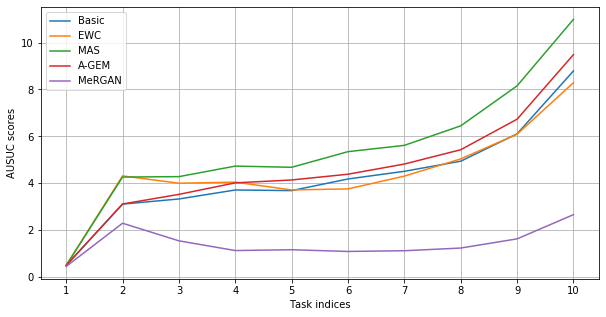

In [104]:
from tqdm import tqdm

plt.figure(figsize=(10, 5))
all_ausuc_histories = []
task_indices = np.arange(1, 11)

for method in methods:
    curr_ausuc_histories = []
    
    for hpo_exp_key, hpo_exp_value in hpo_exps[method]:
        curr_hpo_idx = [i for i, c in enumerate(configs[method]) if c.get(hpo_exp_key) == hpo_exp_value]
        random_seeds = [configs[method][i].random_seed for i in curr_hpo_idx]
        curr_logits = [logits[method][i] for i in curr_hpo_idx]
        curr_targets = [load_labels(s) for s in random_seeds]
        curr_class_splits = [class_splits[method][i] for i in curr_hpo_idx]
        
        ausuc_histories = [compute_joined_ausuc_history(ls, trg, cs) for ls, trg, cs in zip(curr_logits, curr_targets, curr_class_splits)]
        ausuc_histories = np.array(ausuc_histories)
        all_ausuc_histories.append(ausuc_histories)
        curr_ausuc_histories.append(ausuc_histories.mean(axis=0))
        
        #plt.plot(task_indices, ausuc_histories.mean(0), label=f'{method} ({hpo_exp_key}: {hpo_exp_value})')
        
    best_idx = np.array(curr_ausuc_histories)[:, -1].argmax()
    plt.plot(task_indices, curr_ausuc_histories[best_idx], label=f'{method}')

plt.legend()
plt.ylabel('AUSUC scores')
plt.xlabel('Task indices')
plt.xticks(task_indices)
plt.grid()

In [122]:
method = 'A-GEM'
hpo_exp_key = 'hp.optim_kwargs.lr'
hpo_exp_value = 0.03
curr_hpo_idx = [i for i, c in enumerate(configs[method]) if c.get(hpo_exp_key) == hpo_exp_value]
random_seeds = [configs[method][i].random_seed for i in curr_hpo_idx]
curr_logits = [logits[method][i] for i in curr_hpo_idx]
curr_targets = [load_labels(s) for s in random_seeds]
curr_class_splits = [class_splits[method][i] for i in curr_hpo_idx]
accs_matrix = compute_individual_zst_accs_matrix(curr_logits[0][:-1], curr_targets[0], curr_class_splits[0])

In [182]:
def compute_ausuc_matrix(logits_history: np.ndarray, targets: List[int], class_splits: np.ndarray) -> np.ndarray:
    """
    Computes pairwise AUSUC scores between tasks given logits history

    :param logits_history: history of model logits, evaluated BEFORE each task,
                           i.e. matrix of size [NUM_TASKS x DATASET_SIZE x NUM_CLASSES]
    :param targets: targets for the objects of size [DATASET_SIZE]
    :param class_splits: list of classes for each task of size [NUM_TASKS x NUM_CLASSES_PER_TASK]

    :return: AUCSUC value and a matrix of pairwise AUSUCS
    """
    num_tasks = len(logits_history)
    ausuc_matrix = []

    for task_from in range(num_tasks):
        ausucs = []

        for task_to in range(num_tasks):
            classes = set(np.hstack([class_splits[task_to], class_splits[task_from]]))
            curr_logits = [l for l, t in zip(logits_history[task_from], targets) if t in classes]
            curr_targets = [t for t in targets if t in classes]

            classes = list(classes)
            curr_targets = remap_targets(curr_targets, classes)
            seen_classes_mask = np.array([c in class_splits[task_from] for c in classes]).astype(bool)
            ausuc, _ = compute_ausuc(np.array(curr_logits)[:, classes], curr_targets, seen_classes_mask)
            ausucs.append(ausuc)

        ausuc_matrix.append(ausucs)

    return np.array(ausuc_matrix)

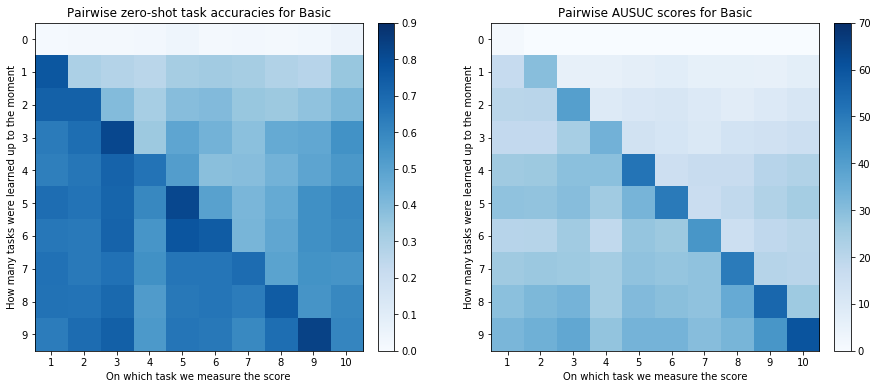

In [210]:
from tqdm import tqdm

plt.figure(figsize=(15, len(methods) * 7))
task_indices = np.arange(1, 11)

for row_i, method in enumerate(methods[:1]):
    hpo_exp_key, hpo_exp_value = hpo_exps[method][best_hpo_results_idx[method]]
    curr_hpo_idx = [i for i, c in enumerate(configs[method]) if c.get(hpo_exp_key) == hpo_exp_value]
    random_seeds = [configs[method][i].random_seed for i in curr_hpo_idx]
    curr_logits = [logits[method][i] for i in curr_hpo_idx]
    curr_targets = [load_labels(s) for s in random_seeds]
    curr_class_splits = [class_splits[method][i] for i in curr_hpo_idx]

    accs_matrix = compute_individual_zst_accs_matrix(curr_logits[0][:-1], curr_targets[0], curr_class_splits[0])
    ausucs_matrix = compute_ausuc_matrix(curr_logits[0][:-1], curr_targets[0], curr_class_splits[0].tolist())
        
    #plt.figure(figsize=(15, 7))

    plt.subplot(5, 2, row_i * 2 + 1)
    plt.title(f'Pairwise zero-shot task accuracies for {method}')
    plt.imshow(accs_matrix, cmap='Blues', vmin=0, vmax=0.9)
    plt.colorbar(fraction=0.046, pad=0.04)
    #plt.clim(0, 1)
    plt.ylabel('How many tasks were learned up to the moment')
    plt.xlabel('On which task we measure the score')
    plt.xticks(task_indices - 1, task_indices);
    plt.yticks(task_indices - 1);

    plt.subplot(5, 2, row_i * 2 + 2)
    plt.title(f'Pairwise AUSUC scores for {method}')
    plt.imshow(ausucs_matrix, cmap='Blues', vmin=0, vmax=70)
    plt.colorbar(fraction=0.046, pad=0.04)
    #plt.clim(0, 100)
    plt.ylabel('How many tasks were learned up to the moment')
    plt.xlabel('On which task we measure the score')
    plt.xticks(task_indices - 1, task_indices);
    plt.yticks(task_indices - 1);